In [1]:
!pip install --upgrade pip
!pip install git+https://github.com/OPTAMI/OPTAMI.git scikit-learn

import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from OPTAMI.second_order.cubic_regularized_newton import CubicRegularizedNewton as CRN
from OPTAMI.first_order.gradient_descent import GradientDescent
from torch.optim import LBFGS, Adam

torch.manual_seed(0)
np.random.seed(0)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/OPTAMI/OPTAMI.git to /tmp/pip-req-build-txi9pa47
  Running command git clone --filter=blob:none --quiet https://github.com/OPTAMI/OPTAMI.git /tmp/pip-req-build-txi9pa47
  Resolved https://github.com/OPTAMI/OPTAMI.git to commit 80b095d9c170d63af66ec72c1e341cdf731e2154
  Preparing metadata (setup.py) ... done
  Created wheel for OPTAMI: filename=OPTAMI-0.0.2-py3-none-any.whl size=50876 sha256=854e0ffbd23fda96a50e2f4de221f9b21a47cc02bda14f3fed9c8a1c3c7191ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-2rglc3_k/wheels/de/52/39/8fa5bf636f12e6264eb7f9da25ee8d5460e9fe8fb59bb4cd0a
Successfully built OPTAMI


In [2]:
data = load_iris()
X_data = data.data  # shape (150, 4)
y_data = data.target
mask = (y_data != 0).astype(float)  # binary 0 = setosa, 1 = not-setosa
X = torch.tensor(X_data, dtype=torch.float32)
y = torch.tensor(mask, dtype=torch.float32)

n_samples, n_features = X.shape
w_init = torch.nn.Parameter(torch.zeros(n_features, requires_grad=True))


In [3]:
def logistic_reg_loss(w, X, y, reg=1e-3):
    # logistic loss: mean(log(1+exp(-y*(Xw)))) + reg/2 * ||w||^2
    y_trans = 2*y - 1
    z = -y_trans * (X @ w)
    loss = torch.mean(torch.log1p(torch.exp(z))) + (reg/2)*torch.sum(w**2)
    return loss

def accuracy(w, X, y):
    with torch.no_grad():
        preds = (torch.sigmoid(X @ w) >= 0.5).float()
        return (preds == y).float().mean().item()


In [4]:
def newton_step(w, X, y, reg=1e-3):
    w.requires_grad_(True)
    loss = logistic_reg_loss(w, X, y, reg)
    grad = torch.autograd.grad(loss, w, create_graph=True)[0]
    # hessian: since problem is small, we can compute full Hessian
    # hessian[i,j] = d^2 loss / dw_i dw_j
    H = []
    for i in range(n_features):
        g_i = torch.autograd.grad(grad[i], w, retain_graph=True)[0]
        H.append(g_i)
    H = torch.stack(H, dim=0)
    w.requires_grad_(False)
    with torch.no_grad():
        # solve H * p = grad for p
        p = torch.linalg.solve(H, grad)
        w_new = w - p
    return w_new


In [5]:
def nesterov_accel_grad(w, X, y, reg=1e-3, lr=0.1, momentum=0.9, steps=20):
    v = torch.zeros_like(w)
    w_hist = []
    loss_hist = []
    for i in range(steps):
        w_intermediate = w + momentum * v
        loss = logistic_reg_loss(w_intermediate, X, y, reg)
        grad = torch.autograd.grad(loss, w_intermediate)[0]

        v_new = momentum * v - lr * grad
        w = w + v_new
        v = v_new

        loss_hist.append(loss.item())
        w_hist.append(w.detach().clone())
    return w, loss_hist


In [6]:
def run_optimizer(method_name, w_init, steps=20, **kwargs):
    w = w_init.clone().detach().requires_grad_(True)
    loss_hist = []
    acc_hist = []
    time_hist = []
    start_time = time.time()

    if method_name == 'CRN':
        optimizer = CRN(params=[w], L=kwargs.get('L',1.0), max_iters=kwargs.get('max_iters',50), rel_acc=kwargs.get('rel_acc',1e-1))

        def closure():
            optimizer.zero_grad()
            loss = logistic_reg_loss(w, X, y)
            loss.backward(create_graph=True)
            return loss

        for i in range(steps):
            t0 = time.time()
            optimizer.step(closure)
            t1 = time.time()
            current_loss = logistic_reg_loss(w, X, y).item()
            current_acc = accuracy(w, X, y)
            loss_hist.append(current_loss)
            acc_hist.append(current_acc)
            time_hist.append(t1 - t0)

    elif method_name == 'GD':
        # gradient descent from OPTAMI
        # need L as lipschitz gradient constant estimate, try something
        optimizer = GradientDescent([w], L=10.0)

        def closure():
            optimizer.zero_grad()
            loss = logistic_reg_loss(w, X, y)
            return loss

        for i in range(steps):
            t0 = time.time()
            optimizer.step(closure)
            t1 = time.time()
            current_loss = logistic_reg_loss(w, X, y).item()
            current_acc = accuracy(w, X, y)
            loss_hist.append(current_loss)
            acc_hist.append(current_acc)
            time_hist.append(t1 - t0)

    elif method_name == 'Newton':
        # each step: newton step manually
        for i in range(steps):
            t0 = time.time()
            w = newton_step(w, X, y, reg=1e-3)
            t1 = time.time()
            current_loss = logistic_reg_loss(w, X, y).item()
            current_acc = accuracy(w, X, y)
            loss_hist.append(current_loss)
            acc_hist.append(current_acc)
            time_hist.append(t1 - t0)

    elif method_name == 'LBFGS':
        optimizer = LBFGS([w], lr=1.0, max_iter=10, line_search_fn='strong_wolfe')
        def closure():
            optimizer.zero_grad()
            loss = logistic_reg_loss(w, X, y)
            loss.backward()
            return loss
        for i in range(steps):
            t0 = time.time()
            optimizer.step(closure)
            t1 = time.time()
            current_loss = logistic_reg_loss(w, X, y).item()
            current_acc = accuracy(w, X, y)
            loss_hist.append(current_loss)
            acc_hist.append(current_acc)
            time_hist.append(t1 - t0)

    elif method_name == 'Adam':
        optimizer = Adam([w], lr=0.1)
        for i in range(steps):
            t0 = time.time()
            optimizer.zero_grad()
            loss = logistic_reg_loss(w, X, y)
            loss.backward()
            optimizer.step()
            t1 = time.time()
            current_loss = loss.item()
            current_acc = accuracy(w, X, y)
            loss_hist.append(current_loss)
            acc_hist.append(current_acc)
            time_hist.append(t1 - t0)

    elif method_name == 'Nesterov':
        t0 = time.time()
        w_final, nesterov_losses = nesterov_accel_grad(w, X, y, lr=0.5, steps=steps)
        t1 = time.time()
        for i, l in enumerate(nesterov_losses):
            loss_hist.append(l)
            acc_hist.append(accuracy(w_final, X, y))
            time_hist.append((t1 - t0)/steps)

    total_time = time.time() - start_time
    return loss_hist, acc_hist, time_hist, total_time


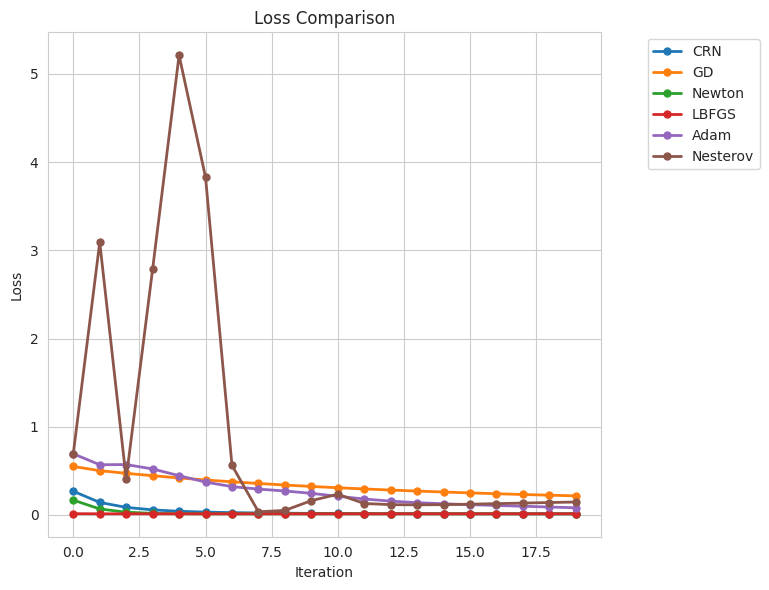

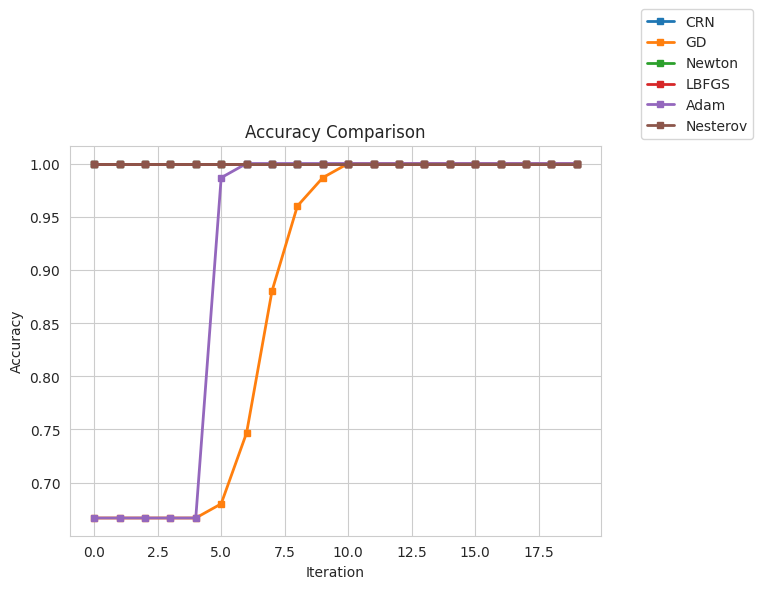

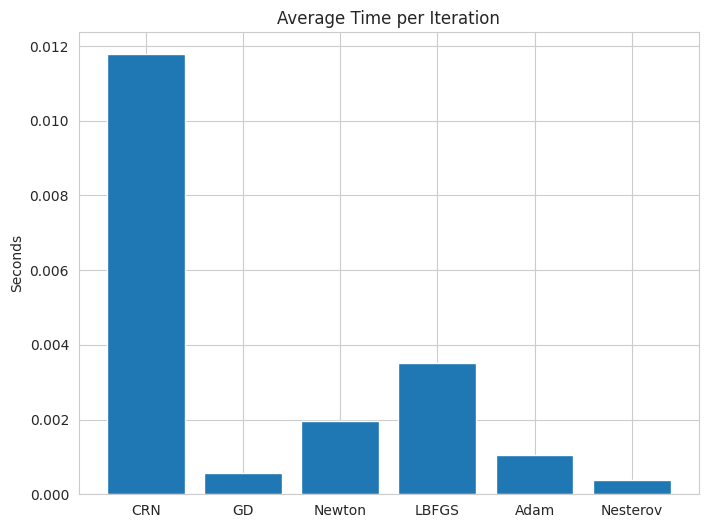

,Final Loss,Final Accuracy,Avg Time/Iter (s),Total Time (s)
Method,,,,
CRN,0.0130,1.0000,0.0118,5.4052
GD,0.2162,1.0000,0.0006,0.0162
Newton,0.0129,1.0000,0.0019,0.0426
LBFGS,0.0129,1.0000,0.0035,0.0751
Adam,0.0814,1.0000,0.0010,0.0226
Nesterov,0.1464,1.0000,0.0004,0.0086


In [10]:
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
palette = sns.color_palette("tab10", n_colors=len(methods))

plt.figure(figsize=(8,6))
for i, m in enumerate(methods):
    plt.plot(results[m]['loss'],
             label=m,
             color=palette[i],
             linewidth=2,
             marker='o',
             markersize=5)
plt.title('Loss Comparison')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i, m in enumerate(methods):
    plt.plot(results[m]['acc'],
             label=m,
             color=palette[i],
             linewidth=2,
             marker='s',
             markersize=5)
plt.title('Accuracy Comparison')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

avg_times = {m: np.mean(results[m]['time_hist']) for m in methods}
plt.figure(figsize=(8,6))
plt.bar(avg_times.keys(), avg_times.values())
plt.title('Average Time per Iteration')
plt.ylabel('Seconds')
plt.show()

summary_data = []
for m in methods:
    final_loss = results[m]['loss'][-1]
    final_acc = results[m]['acc'][-1]
    avg_time = np.mean(results[m]['time_hist'])
    total_time = results[m]['total_time']
    summary_data.append({
        'Method': m,
        'Final Loss': final_loss,
        'Final Accuracy': final_acc,
        'Avg Time/Iter (s)': avg_time,
        'Total Time (s)': total_time
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.set_index('Method')
display(df_summary.style.bar(subset=['Final Loss'], color='#5fba7d').format("{:.4f}"))


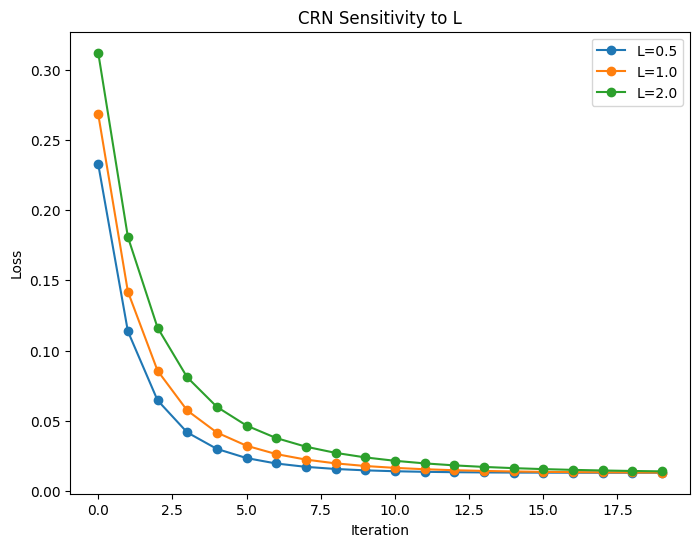

In [8]:
L_values = [0.5, 1.0, 2.0]
plt.figure(figsize=(8,6))
for L_val in L_values:
    loss_hist, _, _, _ = run_optimizer('CRN', w_init, steps=20, L=L_val)
    plt.plot(loss_hist, marker='o', label=f'L={L_val}')
plt.title('CRN Sensitivity to L')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()
